# Linear models last time step prediction

In [10]:
import matplotlib.pyplot as plt
import json
import os
import datetime
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
data_dir = './vaccine_data/hhs_data/'

In [11]:
def convert_to_calender_data(week_offset_from_aug_1,year):
    '''Returns the calender Week'''
    d = "{}-W{}".format(year,week_offset_from_aug_1+31)
    r = datetime.datetime.strptime(d + '-0', "%Y-W%W-%w")
    r = r.strftime("%B %d, %Y")    
    return r

In [12]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [13]:
train_years = ['2013','2014']
dev_years = ['2015']
test_years = ['2016','2017']

train_download_dir = ('train',train_years)
dev_download_dir = ('dev',dev_years)
test_download_dir = ('test',test_years)
data_split_ls = [train_download_dir,dev_download_dir,test_download_dir]

# States 

In [27]:
## Plotting Year count trends year on year dev

def predict_state(state,threshold_start_pred):
    ### Plottting Code
    fig=plt.figure( dpi= 100)
    for data_split in data_split_ls:
        split,years = data_split
        for year in years:
            data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
            data['percentage']=data['percentage']
            # data = data[['week','count','percentage','disparity','week_start']]
            count_vaccinated_week = (data['percentage']*data['count']).values
            count_vaccinated_week[1:]=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
            count_vaccinated_week[0]=0
            plt.plot(data['week'],count_vaccinated_week,label=state+"_"+year);
            print("Max Week => week_num {}, Date = {}".format(count_vaccinated_week.argmax(),convert_to_calender_data(count_vaccinated_week.argmax(),year)))
    plt.grid()
    plt.title("Vaccination for State {}".format(state))
    plt.xlabel('Weeks, starting from aug-1')
    plt.ylabel('People Vaccinated')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    ### Model Train Code

    split,train_years = train_download_dir
    Y = []
    X = []
    week_means=[]
    for year in train_years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        week_means.append(percent_vaccinated_week)
    week_means=np.asarray(week_means).mean(axis=0)
    for year in train_years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        percent_vaccinated_week = percent_vaccinated_week -  week_means

        initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]

        for i in range(threshold_start_pred,len(percent_vaccinated_week)):
            X.append([week_means[i]]+initial_week_vals)
            Y.append(percent_vaccinated_week[i])


    X = np.asarray(X)
    Y = np.asarray(Y)
    model = linear_model.LinearRegression()
    model.fit(X,Y)
    y_pred = model.predict(X)
    error = metrics.mean_squared_error(y_pred,Y)
    print("Error in last train prediction {} %".format(error*100 ))

    ## Dev Prediction

    split = 'dev'
    year = '2015'
    data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
    percent_vaccinated_week = (data['percentage']).values
    percent_vaccinated_week = percent_vaccinated_week -  week_means

    initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]
    Y = []
    X = []
    for i in range(threshold_start_pred,len(percent_vaccinated_week)):
        X.append([week_means[i]]+initial_week_vals)
        Y.append(percent_vaccinated_week[i])

    X = np.asarray(X)
    Y = np.asarray(Y)

    y_pred = model.predict(X)
    error = metrics.mean_squared_error(y_pred,Y)
    print("State: {} Error in last dev prediction {}% for year = {}".format(state, error*100, year ))

    ## Test Prediction

    split = 'test'
    years = ['2016','2017']
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'{}.json'.format(state))))
        percent_vaccinated_week = (data['percentage']).values
        percent_vaccinated_week = percent_vaccinated_week -  week_means[0:len(percent_vaccinated_week)]

        initial_week_vals = [percent_vaccinated_week[i] for i in range(0,threshold_start_pred)]
        Y = []
        X = []
        for i in range(threshold_start_pred,len(percent_vaccinated_week)):
            X.append([week_means[i]]+initial_week_vals)
            Y.append(percent_vaccinated_week[i])

        X = np.asarray(X)
        Y = np.asarray(Y)
        y_pred = model.predict(X)
        error = metrics.mean_squared_error(y_pred,Y)
        print("State: {} Error in last test prediction = {} % for year {}".format(state, error*100,year ))

    print("State:{} Model Coeff {},".format(state,model.coef_))



In [30]:
states = ['WA','AK','CO','CT','NJ','MT','CA','NY']


----------
State = WA With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 9, Date = October 12, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


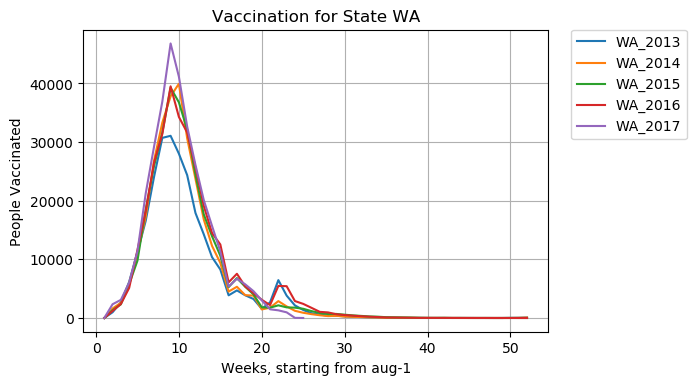

Error in last train prediction 0.001602764248753229 %
State: WA Error in last dev prediction 0.004561689233382542% for year = 2015
State: WA Error in last test prediction = 0.007945966196030583 % for year 2016
State: WA Error in last test prediction = 0.013777341813508537 % for year 2017
State:WA Model Coeff [-1.45367172e-17  1.17488030e+00  2.17611874e+00  1.35392456e+00],
----------
State = AK With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 7, Date = September 28, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 9, Date = October 08, 2017


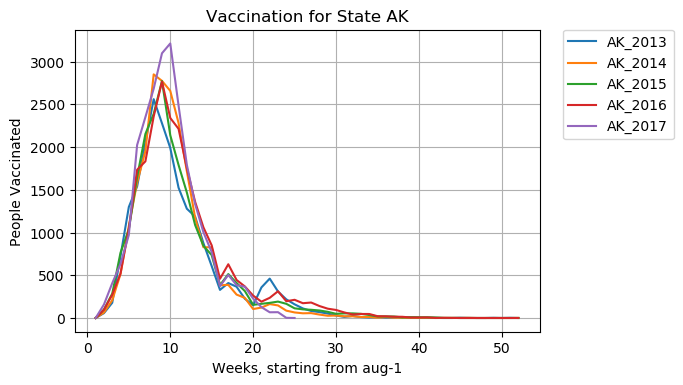

Error in last train prediction 0.001969544312655769 %
State: AK Error in last dev prediction 0.013957526754209549% for year = 2015
State: AK Error in last test prediction = 0.00547631961331444 % for year 2016
State: AK Error in last test prediction = 0.15426131808625598 % for year 2017
State:AK Model Coeff [ 6.76142004e-18 -6.39667537e+00 -6.78079983e+00 -1.07207411e+01],
----------
State = CO With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


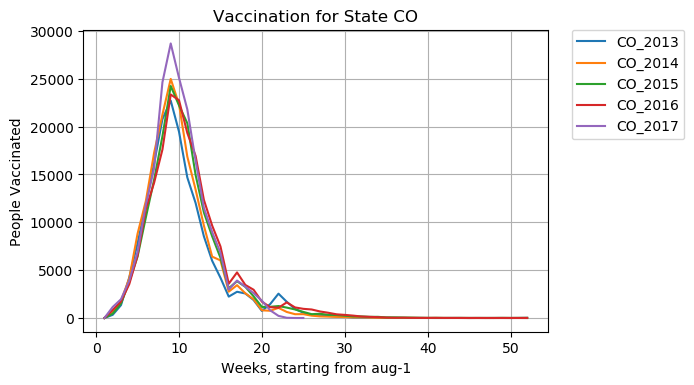

Error in last train prediction 0.0006066249807269906 %
State: CO Error in last dev prediction 0.05545306556482947% for year = 2015
State: CO Error in last test prediction = 0.05478100707618434 % for year 2016
State: CO Error in last test prediction = 0.06026519876024017 % for year 2017
State:CO Model Coeff [-1.57832106e-17 -1.45009134e-01 -3.06899200e-01 -4.67074973e-01],
----------
State = CT With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 10, Date = October 15, 2017


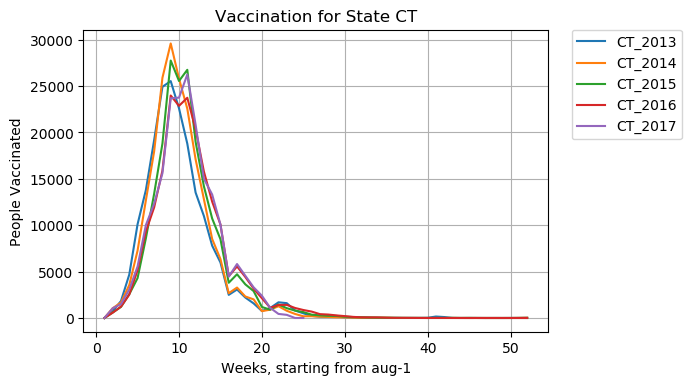

Error in last train prediction 0.0014190367199466891 %
State: CT Error in last dev prediction 0.0795347457496253% for year = 2015
State: CT Error in last test prediction = 0.13114342818992988 % for year 2016
State: CT Error in last test prediction = 0.2856714292596887 % for year 2017
State:CT Model Coeff [-3.89532861e-18  2.09344624e-02  4.07221490e-02  2.21100817e-02],
----------
State = NJ With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


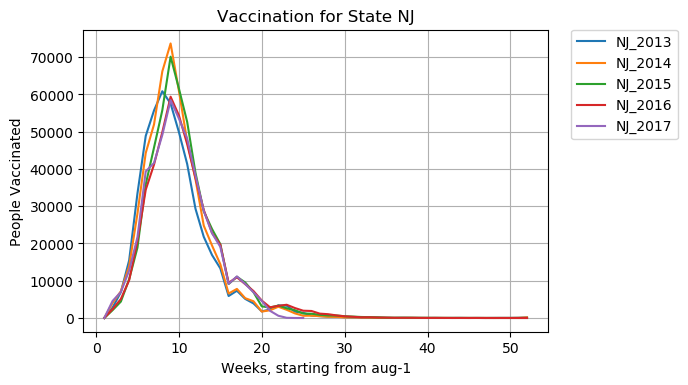

Error in last train prediction 0.0012261290234733442 %
State: NJ Error in last dev prediction 0.07703406625806036% for year = 2015
State: NJ Error in last test prediction = 0.10539896950687358 % for year 2016
State: NJ Error in last test prediction = 0.22080664962762375 % for year 2017
State:NJ Model Coeff [1.39377269e-17 1.60396081e-01 2.65559972e-01 2.36799778e-01],
----------
State = MT With first 3 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


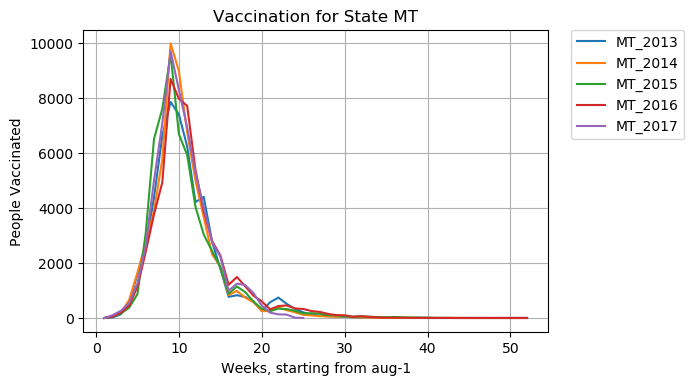

Error in last train prediction 0.000907818715871837 %
State: MT Error in last dev prediction 0.028538828795125266% for year = 2015
State: MT Error in last test prediction = 0.03179094241346057 % for year 2016
State: MT Error in last test prediction = 0.020835750302485936 % for year 2017
State:MT Model Coeff [ 2.01637429e-18 -7.59434050e-01 -2.10840965e+00 -3.47718054e+00],
----------
State = CA With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


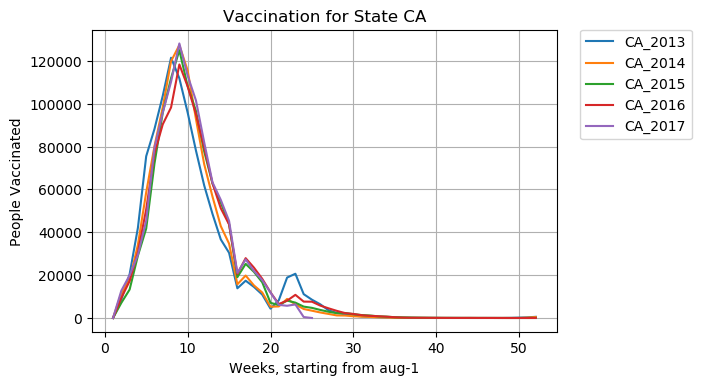

Error in last train prediction 0.0016718228056820067 %
State: CA Error in last dev prediction 0.15499798992883% for year = 2015
State: CA Error in last test prediction = 0.1255101606103916 % for year 2016
State: CA Error in last test prediction = 0.15419350341131385 % for year 2017
State:CA Model Coeff [-5.01062892e-18 -1.30764043e+00 -2.07666009e+00 -1.05445818e+00],
----------
State = NY With first 3 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


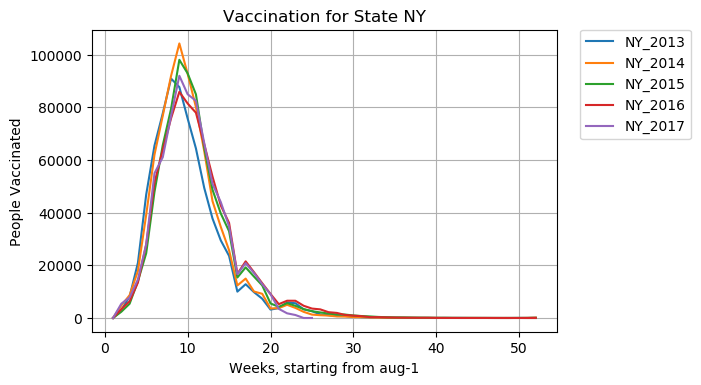

Error in last train prediction 0.00107283749428384 %
State: NY Error in last dev prediction 0.06507182923518047% for year = 2015
State: NY Error in last test prediction = 0.07816976651777373 % for year 2016
State: NY Error in last test prediction = 0.1962977714382823 % for year 2017
State:NY Model Coeff [ 1.43630829e-17 -2.72649436e-02 -5.19297866e-02 -4.86428877e-02],


In [31]:
start_week = 3
for state in states:
    print("-"*10)
    print("State = {} With first {} weeks".format(state,start_week))
    print("-"*10)
    predict_state(state,start_week)

# First 4 weeks

----------
State = WA With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 9, Date = October 12, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


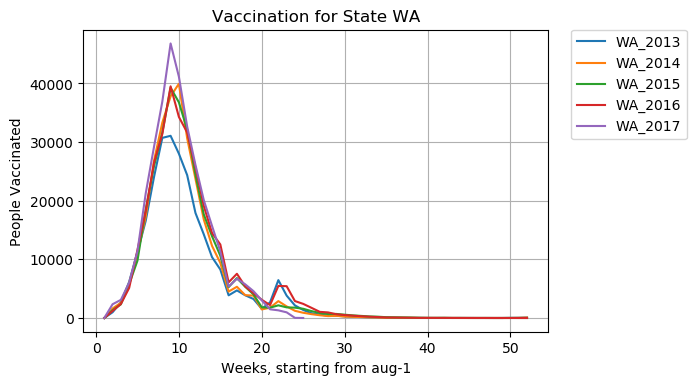

Error in last train prediction 0.0016085333887604178 %
State: WA Error in last dev prediction 0.006889337784748954% for year = 2015
State: WA Error in last test prediction = 0.009107388661237007 % for year 2016
State: WA Error in last test prediction = 0.01483522761295438 % for year 2017
State:WA Model Coeff [-1.78592027e-17  1.14225421e+00  2.11568854e+00  1.31632646e+00
 -6.23379139e-01],
----------
State = AK With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 7, Date = September 28, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 9, Date = October 08, 2017


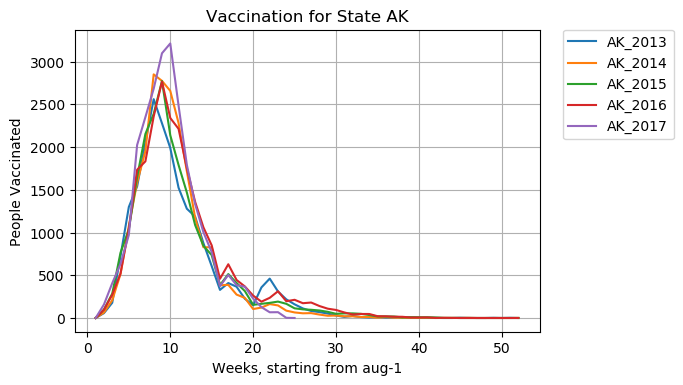

Error in last train prediction 0.0019948010730920147 %
State: AK Error in last dev prediction 0.13531950847560464% for year = 2015
State: AK Error in last test prediction = 0.033689270411615325 % for year 2016
State: AK Error in last test prediction = 0.04037581462761225 % for year 2017
State:AK Model Coeff [ 7.14451340e-18 -1.74164227e-01 -1.84622901e-01 -2.91896881e-01
  2.32630871e+00],
----------
State = CO With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


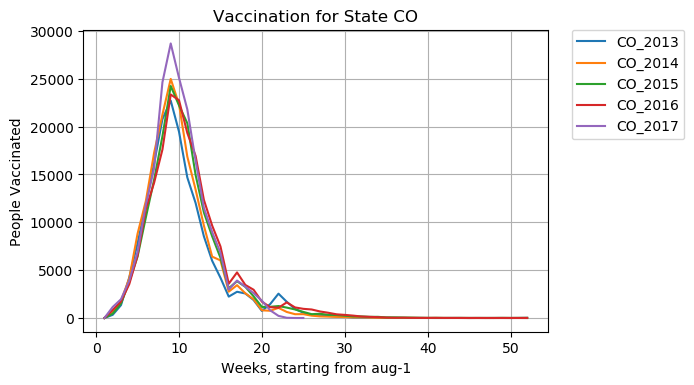

Error in last train prediction 0.0006139880704712473 %
State: CO Error in last dev prediction 0.059312165310009726% for year = 2015
State: CO Error in last test prediction = 0.05840656485638696 % for year 2016
State: CO Error in last test prediction = 0.06529274979342864 % for year 2017
State:CO Model Coeff [-2.15203646e-17 -1.29056398e-01 -2.73136623e-01 -4.15691148e-01
 -2.07723864e-01],
----------
State = CT With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 10, Date = October 15, 2017


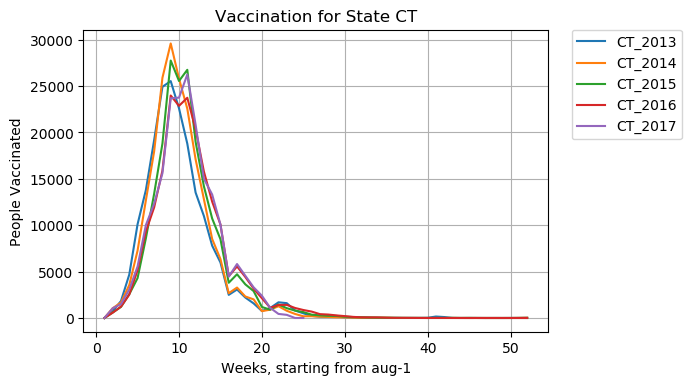

Error in last train prediction 0.0014437462317368707 %
State: CT Error in last dev prediction 0.08270320092548297% for year = 2015
State: CT Error in last test prediction = 0.13578849261332157 % for year 2016
State: CT Error in last test prediction = 0.3004761788579338 % for year 2017
State:CT Model Coeff [-4.12669956e-18  1.08385930e-02  2.10834551e-02  1.14472573e-02
 -3.83796836e-02],
----------
State = NJ With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


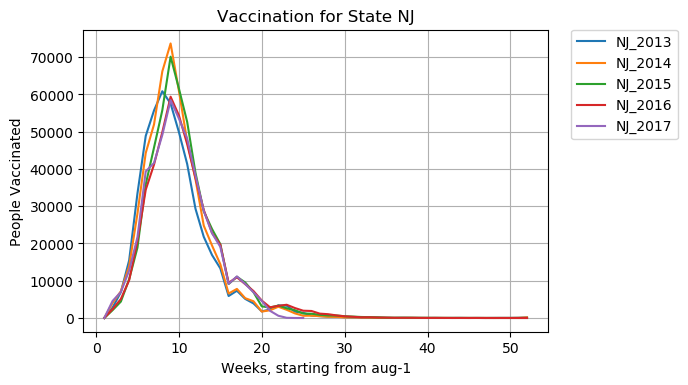

Error in last train prediction 0.0012497327923141272 %
State: NJ Error in last dev prediction 0.08039545111614123% for year = 2015
State: NJ Error in last test prediction = 0.1093861676546682 % for year 2016
State: NJ Error in last test prediction = 0.23186499312456152 % for year 2017
State:NJ Model Coeff [ 1.69436753e-17  1.62968531e-01  2.69819053e-01  2.40597599e-01
 -3.95824810e-02],
----------
State = MT With first 4 weeks
----------
Max Week => week_num 8, Date = October 06, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


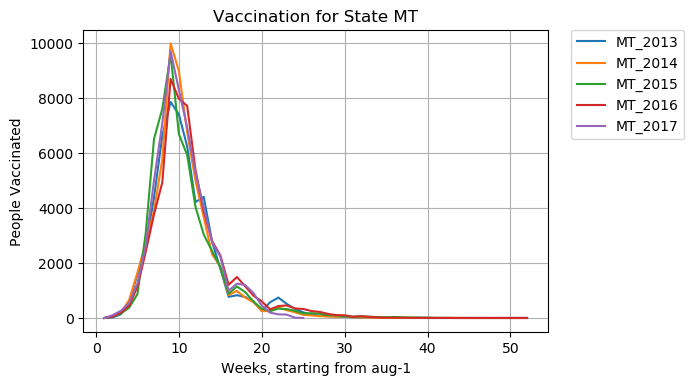

Error in last train prediction 0.0009076304447981775 %
State: MT Error in last dev prediction 0.042286321282519135% for year = 2015
State: MT Error in last test prediction = 0.043819777972468166 % for year 2016
State: MT Error in last test prediction = 0.02987980331515148 % for year 2017
State:MT Model Coeff [ 2.63395079e-18 -2.98636644e-01 -8.29102120e-01 -1.36735181e+00
 -2.06552500e+00],
----------
State = CA With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


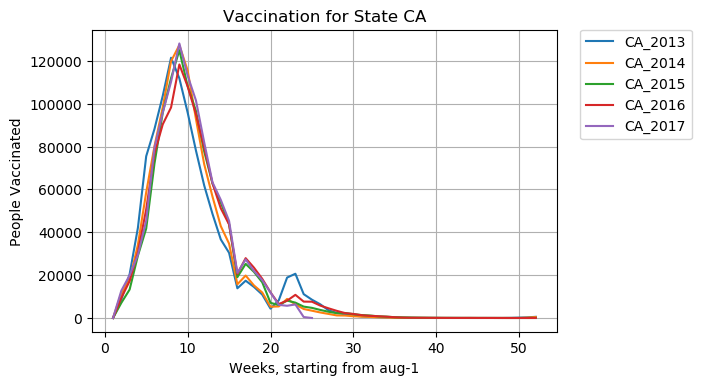

Error in last train prediction 0.0016769332058229165 %
State: CA Error in last dev prediction 0.058028350591227094% for year = 2015
State: CA Error in last test prediction = 0.06737524897912853 % for year 2016
State: CA Error in last test prediction = 0.11665119750004099 % for year 2017
State:CA Model Coeff [-6.71625344e-18 -9.06481056e-01 -1.43958002e+00 -7.30970338e-01
  1.26252243e+00],
----------
State = NY With first 4 weeks
----------
Max Week => week_num 7, Date = September 29, 2013
Max Week => week_num 8, Date = October 05, 2014
Max Week => week_num 8, Date = October 04, 2015
Max Week => week_num 8, Date = October 02, 2016
Max Week => week_num 8, Date = October 01, 2017


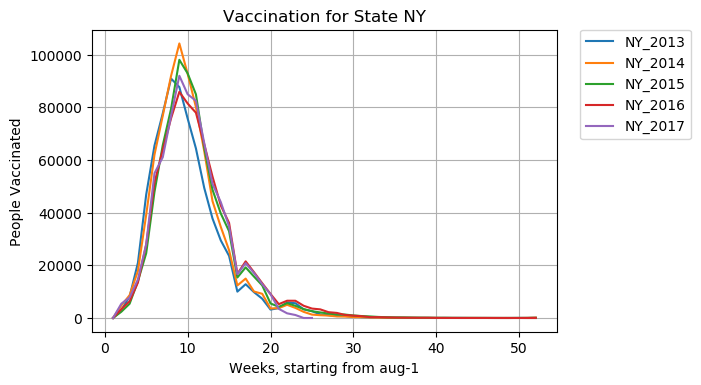

Error in last train prediction 0.0010945742609139535 %
State: NY Error in last dev prediction 0.06511789178554464% for year = 2015
State: NY Error in last test prediction = 0.07872484731593055 % for year 2016
State: NY Error in last test prediction = 0.2051362319113533 % for year 2017
State:NY Model Coeff [ 1.63439473e-17 -2.03999045e-02 -3.88543875e-02 -3.63950968e-02
  2.55396229e-02],


In [32]:
start_week = 4
for state in states:
    print("-"*10)
    print("State = {} With first {} weeks".format(state,start_week))
    print("-"*10)
    predict_state(state,start_week)